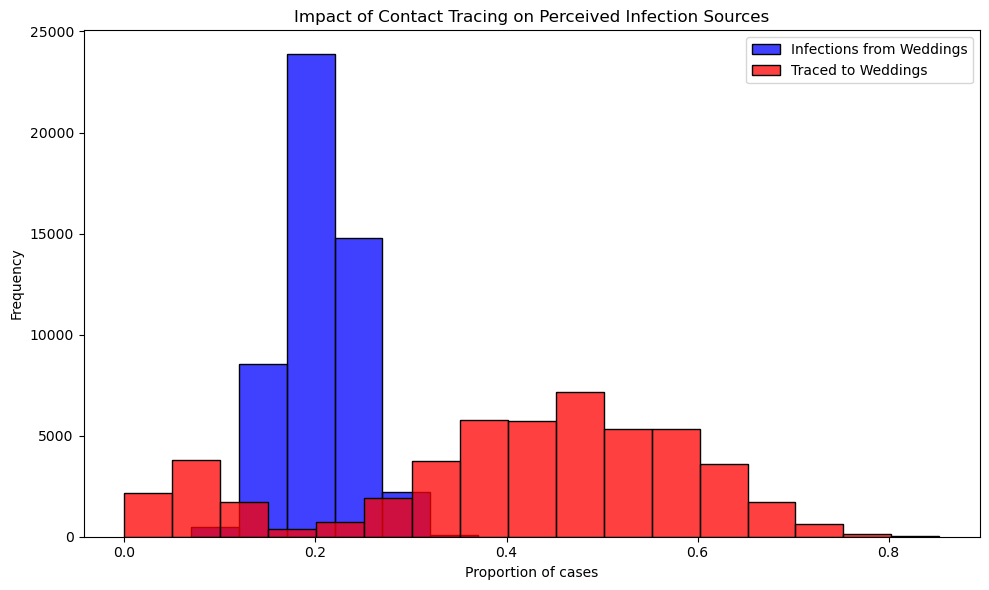

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2
np.random.seed(42)

def simulate_event(m):
    """
    Simulates the infection and tracing process for a series of events.

    This function creates a DataFrame representing individuals attending specific weddings and brunches,
    infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
    and calculates the proportions of infections and traced cases that are attributed to weddings.

    Parameters:
    - m: Dummy parameter for iteration purposes.

    Returns:
    - A tuple containing the proportion of infections and the proportion of traced cases
      that are attributed to weddings.
    """
    # Create DataFrame for people at events with initial infection and traced status
    # Assign individuals to specific weddings and brunches
    wedding_attendees = []
    for wedding_id in range(1, 3):  # Two weddings
        for person_id in range(100):  # 100 people per wedding
            wedding_attendees.append({
                'event_type': 'wedding',
                'event_id': f'Wedding_{wedding_id}',
                'infected': False,
                'traced': np.nan
            })

    brunch_attendees = []
    for brunch_id in range(1, 81):  # 80 brunches
        for person_id in range(10):  # 10 people per brunch
            brunch_attendees.append({
                'event_type': 'brunch',
                'event_id': f'Brunch_{brunch_id}',
                'infected': False,
                'traced': np.nan
            })

    # Combine attendees into one DataFrame
    ppl = pd.DataFrame(wedding_attendees + brunch_attendees)

    # Explicitly set 'traced' column to nullable boolean type
    ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

    # Infect a random subset of people
    total_people = len(ppl)
    num_infected = int(total_people * ATTACK_RATE)
    infected_indices = np.random.choice(ppl.index, size=num_infected, replace=False)
    ppl.loc[infected_indices, 'infected'] = True

    # Primary contact tracing: randomly decide which infected people get traced
    primary_traced = np.random.rand(num_infected) < TRACE_SUCCESS
    ppl.loc[infected_indices, 'traced'] = primary_traced

    # Secondary contact tracing based on specific event attendance
    traced_infections = ppl[ppl['traced'] == True]
    event_trace_counts = traced_infections['event_id'].value_counts()
    events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
    # Set 'traced' to True for all infected individuals at these events
    for event in events_traced:
        ppl.loc[(ppl['event_id'] == event) & (ppl['infected']), 'traced'] = True

    # Calculate proportions of infections and traces attributed to weddings
    wedding_infections = ppl[(ppl['infected']) & (ppl['event_type'] == 'wedding')].shape[0]
    brunch_infections = ppl[(ppl['infected']) & (ppl['event_type'] == 'brunch')].shape[0]
    total_infections = wedding_infections + brunch_infections
    p_wedding_infections = wedding_infections / total_infections

    wedding_traces = ppl[(ppl['infected']) & (ppl['traced'] == True) & (ppl['event_type'] == 'wedding')].shape[0]
    brunch_traces = ppl[(ppl['infected']) & (ppl['traced'] == True) & (ppl['event_type'] == 'brunch')].shape[0]
    total_traces = wedding_traces + brunch_traces

    # Handle division by zero if no traces
    if total_traces > 0:
        p_wedding_traces = wedding_traces / total_traces
    else:
        p_wedding_traces = np.nan

    return p_wedding_infections, p_wedding_traces

# Run the simulation 50000 times
results = [simulate_event(m) for m in range(50000)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])
props_df.dropna(inplace=True)  # Remove simulations with zero traces to avoid NaN

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()